# Detecção de Ataque DDoS com Machine Learning
---
---

### Informações importantes

In [1]:
# O código inteiro foi feito e testado no Kaggle porque o dataset original CIC-DDoS2019 é MUITO pesado (30 GB) 
# para rodarmos em nossos computadores pessoais. Link do dataset original: https://www.unb.ca/cic/datasets/ddos-2019.html

# No kaggle utilizamos um dataset criado por um usuário que é 5% do tamanho do dataset original.
# Este dataset de 5% pode ser encontrado aqui: https://www.kaggle.com/datasets/manmandes/cicddos2019-5percent


# ----- Exportar Arquivo Kaggle -----
# df.to_csv('mycsvfile.csv',index=False)

# ----- Deletar Arquivo Kaggle -----
# os.remove("/kaggle/working/<arquivo>")

## 1) Importação das Bibliotecas e Ferramentas Utilizadas

In [12]:
import time
import pandas                           as pd
import numpy                            as np
import matplotlib.pyplot                as plt
import hashlib
import tensorflow

from sklearn.model_selection            import train_test_split
from sklearn.metrics                    import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection          import VarianceThreshold
from sklearn.preprocessing              import MinMaxScaler
from sklearn.decomposition              import PCA
from sklearn.naive_bayes                import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB
from sklearn.utils                      import resample
from tensorflow                         import keras
from keras.utils                        import np_utils, to_categorical
from keras.callbacks                    import EarlyStopping
from keras                              import Sequential
from keras.layers                       import Dense

### ----- Funções Auxiliares -----

In [13]:
# --------------------- Pré-processamento dos Dados ---------------------

def preProcessamento(df, threshold):
    print("Qtd colunas ANTES do pré-processamento: {}".format(df.shape[1]))

    drop_columns = ['Unnamed: 0.1','Unnamed: 0','Source IP','Destination IP','Source Port','Destination Port',
                'Timestamp','SimillarHTTP','Flow ID','Fwd Header Length.1','Inbound']
    # Remover colunas geradas pelo CICFlowMeter-V3
    df.drop(labels=drop_columns, axis=1, inplace=True)

    print("Qtd colunas após drop: {}".format(df.shape[1]))

    # Altera nome dos ataques
    old_labels = ['DrDoS_NetBIOS','DrDoS_MSSQL','DrDoS_UDP','DrDoS_DNS','DrDoS_LDAP','Syn','DrDoS_NTP',
                 'DrDoS_SNMP','DrDoS_SSDP']
    new_labels = ['NetBIOS','MSSQL','UDP','DNS','LDAP','SYN','NTP','SNMP','SSDP']
    df['Label'].replace(old_labels, new_labels, inplace=True)

    # Remover linhas com valores Infinitos e NaN
    df.replace([np.inf,-np.inf], np.nan, inplace=True)    
    df.dropna(inplace=True)

    # Remover linhas duplicadas
    df.drop_duplicates(inplace=True)
    
    # Remover colunas com variância dado limite (nulo, por exemplo)
    df = variance(df, threshold)
          
    print("Qtd colunas APÓS o pré-processamento: {}".format(df.shape[1]))
    
    return df

# --------------------- Dividir Dados em Conjunto de df e Teste ---------------------

def train_test(samples, train, seed):
    # Pega os dados de entrada
    X = samples.iloc[:,0:(samples.shape[1]-1)]
    
    # Pega os alvos
    y = samples.iloc[:,-1]
    
    # Divide os dados em conjuntos de df e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train, random_state=seed, shuffle=True)
    
    return X_train, X_test, y_train, y_test

# --------------------- Normalizar Dados ---------------------

def normalize_data(X_train, X_test):
    # Define o scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    # Scala o conjunto de df
    X_train = scaler.transform(X_train)
    # Scala o conjunto de teste
    X_test = scaler.transform(X_test)
    print("Dados de Entrada Normalizados com Sucesso!")
    
    return X_train, X_test

# --------------------- Colunas Altamente Correlacionadas com o 'Label' (Alvo) ---------------------

def correlation_cols_with_target(df):
    corrMatrix = df.corr()
    # Limite para a correlação (ex: 0.5 para alta correlação positiva)
    limit = 0.5
    # Selecione colunas com alta correlação com o alvo 'target' ou entre si
    cols_highly_corr = corrMatrix[corrMatrix['Label'] > limit].index
    
    return highly_correlated_columns

# --------------------- Colunas Fraca ou Moderadamente Correlacionadas entre Si ---------------------

# with the following function we can select highly corrolated features
# it will remove the first feature that is corrolated with anything other feature
def correlation_cols(dataset,threshold):
    col_corr = set()                   #set of all the names of corrolated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) < threshold:
                colname = corr_matrix.columns[i]            #getting the name of column
                col_corr.add(colname)
                
    return col_corr

#ncorr_features = correlation_cols(x_train, 0.7)
#len(set(ncorr_features))

# --------------------- Tira colunas dado limite de variancia ---------------------

def variance(df, limit):
    X = df.values[:, 0:len(df.columns)-1] # Pega todos valores das colunas, exceto da coluna 'Label'
    v_threshold = VarianceThreshold(threshold=limit)
    v_threshold.fit(X)
    cols_bool = v_threshold.get_support() # Vetor booleano onde True significa que a coluna tem variação > limit
    cols_bool = np.append(cols_bool, True) # Retorna com a coluna 'Label'
    cols = df.columns[cols_bool]
    
    return df[cols] # Dataset já com as colunas retiradas

# --------------------- Validação Cruzada para MLP implementado no Keras ---------------------

def mlp_manual_cross_validation(model, X, y, k):
    
    # 'StratifiedKFold' é ideal para problemas de classificação multiclasses desbalanceados porque mantém a proporção de classes em cada dobra.
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    print('MLP:\n')
    y_encoded = np_utils.to_categorical(y)

    k = 5  # Número de dobras para validação cruzada
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    cv_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0, callbacks=[early_stopping])

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)  # Obtém a classe prevista

        y_true_classes = np.argmax(y_test, axis=1)  # Obtém a classe verdadeira

        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        cv_scores.append(accuracy)

    # Exiba os resultados
    print(f"Resultados da Validação Cruzada ({k}-fold):")
    print("Exatidão em cada dobra:", cv_scores)
    print(f"Exatidão Média na Validação Cruzada: {np.mean(cv_scores)}")
    print(f"Desvio Padrão na Validação Cruzada: {np.std(cv_scores)}")

# --------------------- Classe SMOTE - Gerar novos dados sintéticos nas classes minoritárias ---------------------

def oversample_with_smote(df, column, strategy, seed):
    from imblearn.over_sampling import SMOTE

    X = df.drop(columns=[column])
    y = df[column]

    # Criar uma instância de SMOTE
    smote = SMOTE(sampling_strategy=strategy, random_state=seed)
    
    # Aplicar SMOTE para gerar amostras sintéticas
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # DataFrame com as amostras oversampled
    df_oversampled = pd.concat([X_resampled, y_resampled], axis=1)

    # Exibir o DataFrame resultante
    print("SMOTE feito com sucesso!")
    print('Quantidade de amostras agrupadas por {}\n'.format(column))
    print(df_oversampled[column].value_counts().sort_index())
    
    return df_oversampled

# --------------------- Balanceamento de dados com RandomOverSampler - Duplicando amostras de classes minoritárias ---------------------

def oversample_with_RandomOverSampler(df, column):
    
    from imblearn.over_sampling import RandomOverSampler

    X = df.drop([column], axis=1)
    Y = df[column]

    # balanceando usando oversampling
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X,Y)

    # Reatribuindo ao dataset df
    df = X_resampled
    
    if column == 'Label':
        df['Label'] = y_resampled
    else:
        df.insert(0, column, y_resampled)
    
    print("RandomOverSampler feito com sucesso!")
    
    return df

# --------------------- Balanceamento de dados com RandomUnderSampler - Remove amostras de classes majoritárias ---------------------

def undersample_with_RandomUnderSampler(df, column, strategy):
    
    from imblearn.under_sampling import RandomUnderSampler
    
    X = df.drop([column], axis=1)
    Y = df[column]

    # balanceando usando oversampling
    rus = RandomUnderSampler(sampling_strategy=strategy, random_state=0)
    X_resampled, y_resampled = rus.fit_resample(X,Y)

    # Reatribuindo ao dataset df
    df = X_resampled
    
    if column == 'Label':
        df['Label'] = y_resampled
    else:
        df.insert(0, column, y_resampled)
    
    print("RandomUnderSampler feito com sucesso!")
    
    return df

# --------------------- Calcula e exibe TODAS as métricas de problemas de classificação ---------------------

def metrics_score(y_true, y_pred):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    y_true = y_true.map(mapear_valores)
    y_pred = pd.Series(y_pred).map(mapear_valores)
    
    report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print('Acurácia: \t{:.2f}'.format(accuracy * 100))
    print('Precisão: \t{:.2f}'.format(precision * 100))
    print('Recall: \t{:.2f}'.format(recall * 100))
    print('F1-Score: \t{:.2f}'.format(f1 * 100))
    print('ROC-AUC: \t{:.2f}'.format(roc_auc * 100))
    print('Relatório de Classificação: \n{}'.format(report))
    #print('Matriz de Confusão: \n{}'.format(cm))

    # --------------------- Compara listas ---------------------
    
def compare_lists(list1, list2):
    # Verifica se as listas têm o mesmo comprimento
    #if len(list1) != len(list2):
    #    return "As listas são de tamanhos diferentes."

    # Inicializa uma lista para armazenar os elementos diferentes
    differences = []

    # Itera sobre os índices das listas e verifica se os elementos são iguais
    for i in range(len(list1)):
        if list1[i] not in list2[i]:
            differences.append(list1[i])  # Adiciona os elementos diferentes à lista

    if len(differences) == 0:
        return "As listas são iguais."
    else:
        return f"Itens que a list2 não tem que a list1 tem: {differences}"

# --------------------- Mapeia valores inteiros para o nome dos ataques ---------------------

def mapear_valores(valor):
    if valor == 0:
        return 'BENIGN'
    elif valor == 1:
        return 'DDoS'

In [14]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix")
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
    )


## 2) Leitura de Arquivos e Pré-processamento de Dados
---

### Lendo Arquivos

In [15]:
path = '/kaggle/input/cicddos2019-5percent/5percent'
rows = 1000000

# -----> TREINO
df_ldap = pd.read_csv(path + '/01-12/5percent_DrDoS_LDAP.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_mssql = pd.read_csv(path + '/01-12/5percent_DrDoS_MSSQL.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_netBios = pd.read_csv(path + '/01-12/5percent_DrDoS_NetBIOS.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_udp = pd.read_csv(path + '/01-12/5percent_DrDoS_UDP.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_syn = pd.read_csv(path + '/01-12/5percent_Syn.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_dns = pd.read_csv(path + '/01-12/5percent_DrDoS_DNS.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_ntp = pd.read_csv(path + '/01-12/5percent_DrDoS_NTP.csv', encoding='UTF-8', low_memory=False, nrows=rows)

df_tftp = pd.read_csv(path + '/01-12/5percent_TFTP.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_udpLag = pd.read_csv(path + '/01-12/5percent_UDPLag.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_snmp = pd.read_csv(path + '/01-12/5percent_DrDoS_SNMP.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_ssdp = pd.read_csv(path + '/01-12/5percent_DrDoS_SSDP.csv', encoding='UTF-8', low_memory=False, nrows=rows)
df_portmap = pd.read_csv(path + '/03-11/5percent_Portmap.csv', encoding='UTF-8', low_memory=False, nrows=rows)

In [59]:
# Juntando arquivos lidos
files = [df_ldap,df_mssql,df_netBios,df_udp,df_syn,df_dns,df_ntp,df_tftp,df_udpLag,df_snmp,df_ssdp,df_portmap]

df_files = pd.DataFrame()._append(files, ignore_index=True)

# Pré-processamento de dados
df_files = preProcessamento(df_files, 0)
df_files = df_files[df_files['Label'] != 'WebDDoS']  # Retira ataque WebDDoS porque tinha pouca quantidade segundo os próprios autores do dataset.
df_files = df_files[df_files['Protocol'] != 0]       # Retira linhas com Protocolo = 0 (tinham apenas 105 linhas e os resultados foram melhores sem elas)
#Explicação: Como o trabalho classifica ataques DDoS na camada de aplicação, ataques com protocolo = 0 nunca seriam interpretados como derivado de TCP/UDP

# Configurar pandas para mostrar todas as colunas em um print
#pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

df_files.shape

Qtd colunas ANTES do pré-processamento: 89
Qtd colunas após drop: 78
Qtd colunas APÓS o pré-processamento: 66


(639175, 66)

In [60]:
df = df_files

In [61]:
# Quantidade de amostras por protocolo está desbalanceado
print("{}\n".format(df.groupby('Protocol')['Label'].count()) )
print("{}\n".format(df.groupby('Protocol')['Label'].unique()) )
print(df['Label'].value_counts().sort_index())
print("\ndf: {}".format(df.shape))

Protocol
6      16101
17    623074
Name: Label, dtype: int64

Protocol
6     [BENIGN, LDAP, MSSQL, NetBIOS, UDP, SYN, DNS, ...
17    [LDAP, BENIGN, MSSQL, NetBIOS, UDP, SYN, DNS, ...
Name: Label, dtype: object

Label
BENIGN       2870
DNS         15552
LDAP         4982
MSSQL       32639
NTP         56767
NetBIOS      2859
Portmap       279
SNMP        15870
SSDP        61686
SYN          9025
TFTP       357361
UDP         74159
UDP-lag      5126
Name: count, dtype: int64

df: (639175, 66)


In [62]:
# Codificando Alvo
df['Label'] = df['Label'].replace('BENIGN',0)
df['Label'] = df['Label'].replace('LDAP',1)
df['Label'] = df['Label'].replace('MSSQL',1)
df['Label'] = df['Label'].replace('NetBIOS',1)
df['Label'] = df['Label'].replace('UDP',1)
df['Label'] = df['Label'].replace('SYN',1)
df['Label'] = df['Label'].replace('DNS',1)
df['Label'] = df['Label'].replace('NTP',1)
df['Label'] = df['Label'].replace('TFTP',1)
df['Label'] = df['Label'].replace('SSDP',1)
df['Label'] = df['Label'].replace('UDP-lag',1)
df['Label'] = df['Label'].replace('SNMP',1)
df['Label'] = df['Label'].replace('Portmap',1)

In [63]:
#semente_tempo = []

In [64]:
#seed = int(time.time())
#semente_tempo.append(seed)
#print(semente_tempo)

seed = 1699123216  # melhor semente de tempo gerada internamente pelo SMOTE

# -------------------- CENÁRIO 1 --------------------
# Reduz aleatoriamente a quantidade de ataque (1) para 320.000 amostras
#df = undersample_with_RandomUnderSampler(df,'Label',{1: 320000})

# Cria dados sintéticos na classe 0 (BENING) totalizando a qntd. da classe 1 (320.000 amostras).
#df = oversample_with_smote(df,'Label','all',seed)
#print("Qntd linhas após oversample: {}".format(df.shape[0]))
#df = oversample_with_RandomOverSampler(df,'Label')

# -------------------- CENÁRIO 2 --------------------
# Subamostragem aleatória da classe 1 (DDOS) para a qntd da classe 0 (BENIGN) que é 2.870 amostras.
df = undersample_with_RandomUnderSampler(df,'Label','all')

df.drop_duplicates(inplace=True)
#print("Qntd após remoção de linhas duplicadas: {}".format(df.shape[0]))

RandomUnderSampler feito com sucesso!


## 3) Script Principal

---

### Definindo Semente pelo Keras, Aplicando Seleção de Atributos & Dividindo Conjunto de Dados em Treino e Teste

['Subflow Bwd Packets', 'Avg Fwd Segment Size', 'Bwd IAT Min', 'Protocol', 'Bwd Packet Length Mean', 'Init_Win_bytes_forward', 'Down/Up Ratio', 'act_data_pkt_fwd', 'Label']
Dados de Entrada Normalizados com Sucesso!
Dados de Treino: (3787, 8)
Dados de Teste: (1952, 8)
Qntd. Atrib. Matriz: 9


[Text(0.5, 0, 'Subflow Bwd Packets'),
 Text(1.5, 0, 'Avg Fwd Segment Size'),
 Text(2.5, 0, 'Bwd IAT Min'),
 Text(3.5, 0, 'Protocol'),
 Text(4.5, 0, 'Bwd Packet Length Mean'),
 Text(5.5, 0, 'Init_Win_bytes_forward'),
 Text(6.5, 0, 'Down/Up Ratio'),
 Text(7.5, 0, 'act_data_pkt_fwd'),
 Text(8.5, 0, 'Label')]

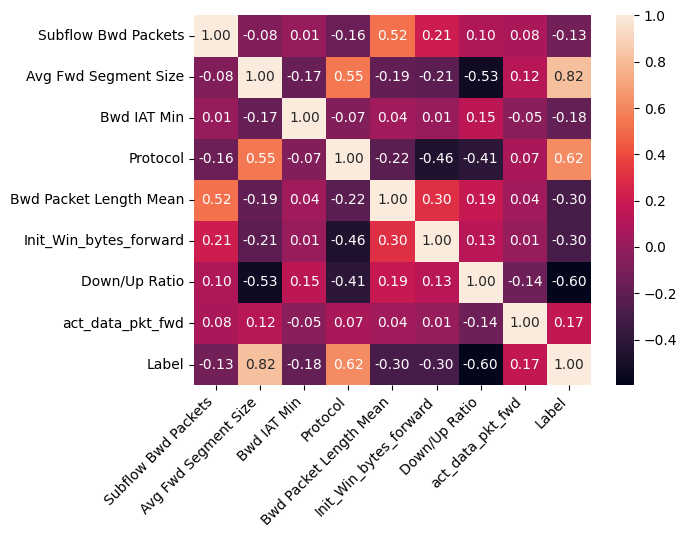

In [65]:
T = df
seed = 42
tensorflow.random.set_seed(seed)

# ------------------------- BINÁRIA - (Qntd: 21 colunas)
# Variance = 0% e 30% features mais importantes pelo RF
#cols = ['Min Packet Length', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Packet Length Mean', 'Subflow Bwd Packets', 'Fwd Packet Length Max', 
#        'Avg Fwd Segment Size', 'Average Packet Size', 'Total Length of Fwd Packets', 'Bwd IAT Min', 'Total Backward Packets', 'Protocol', 
#        'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Init_Win_bytes_forward', 'Subflow Bwd Bytes', 'Down/Up Ratio', 'Max Packet Length', 
#        'Bwd Packet Length Max', 'act_data_pkt_fwd']

cols = ['Subflow Bwd Packets', 'Avg Fwd Segment Size', 'Bwd IAT Min', 'Protocol', 'Bwd Packet Length Mean', 'Init_Win_bytes_forward', 
        'Down/Up Ratio', 'act_data_pkt_fwd']

#cols.remove('Subflow Fwd Bytes')
#cols.remove('Total Length of Fwd Packets')
#cols.remove('Total Backward Packets')
#cols.remove('Average Packet Size')
#cols.remove('Max Packet Length')
#cols.remove('Bwd Packet Length Max')
#cols.remove('Subflow Bwd Bytes')
#cols.remove('Fwd Packet Length Max')
#cols.remove('Min Packet Length')
#cols.remove('Fwd Packet Length Min')
#cols.remove('Fwd Packet Length Mean')
#cols.remove('Packet Length Mean')

cols.append('Label')
T = T.loc[:, cols]
print(cols)
#cols_corr = list(correlation_cols(T, 0.7))
#cols_corr.remove('Label') # Remove coluna 'Label' do meio da lista
#cols_corr.append('Label') # E coloca no final da lista
#T = T.loc[:, cols_corr]
#print(cols_corr)


X_train, X_test, y_trainn, y_test = train_test(T, train=0.66, seed=seed)
# Normaliza dados de entrada ( X )
X_train, X_test = normalize_data(X_train, X_test)

print("Dados de Treino: {}".format(X_train.shape))
print("Dados de Teste: {}".format(X_test.shape))

print("Qntd. Atrib. Matriz: " + str(T.shape[1]))
import seaborn as sns  
ax = sns.heatmap(T.corr(), annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

## 4) Modelos
---

### Naive Bayes Sem PCA

/tmp/ipykernel_32/2958256902.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


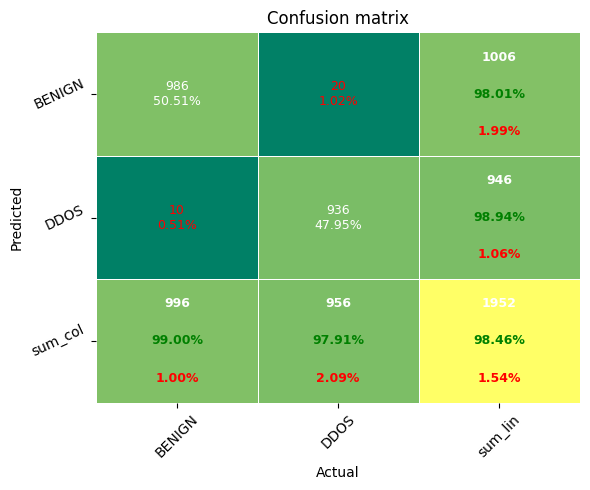

Acurácia: 	98.46
Precisão: 	98.94
Recall: 	97.91
F1-Score: 	98.42
ROC-AUC: 	98.45
Relatório de Classificação: 
              precision    recall  f1-score   support

      BENIGN       0.98      0.99      0.99       996
        DDoS       0.99      0.98      0.98       956

    accuracy                           0.98      1952
   macro avg       0.98      0.98      0.98      1952
weighted avg       0.98      0.98      0.98      1952



In [23]:
# Define Naive Bayes
bayes =  GaussianNB()

# Realiza treinamento
bayes.fit(X_train, y_trainn)

# Realiza predição dos dados de teste
y_pred_nb = bayes.predict(X_test)

# PLOTA MATRIZ DE CONFUSÃO
classes = ['BENIGN','DDOS']    # Binário
pp_matrix_from_data(y_test, y_pred_nb, cmap="summer", columns=classes, show_null_values=1, fz=9, figsize=[6,5])     # Plota)

# Exibe todas as métricas
metrics_score(y_test, y_pred_nb)

### Naive Bayes Com PCA

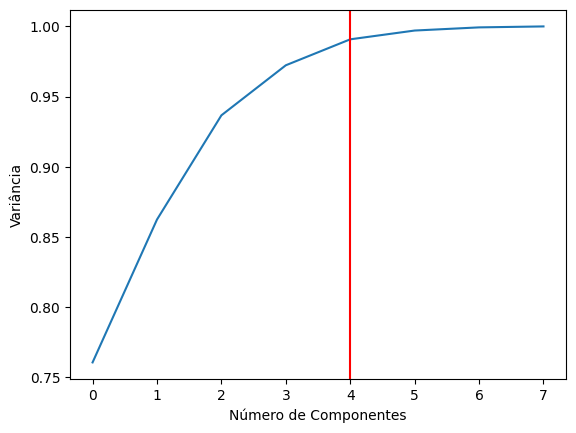

In [24]:
# PCA
pca = PCA()
pca.fit(X_train)

# Imprime o gráfico da porcentagem da variância total dos dados por cada componente
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x = 4, color = 'r', label = 'componentes selecionadas')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância")
plt.show()

/tmp/ipykernel_32/2958256902.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


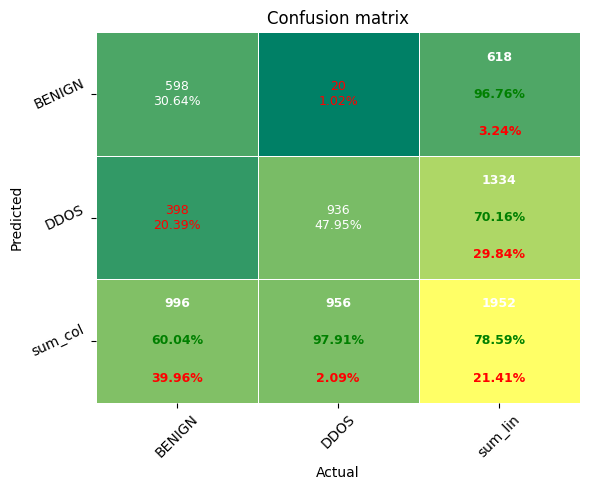

Acurácia: 	78.59
Precisão: 	70.16
Recall: 	97.91
F1-Score: 	81.75
ROC-AUC: 	78.97
Relatório de Classificação: 
              precision    recall  f1-score   support

      BENIGN       0.97      0.60      0.74       996
        DDoS       0.70      0.98      0.82       956

    accuracy                           0.79      1952
   macro avg       0.83      0.79      0.78      1952
weighted avg       0.84      0.79      0.78      1952



In [25]:
# PCA
pca = PCA(n_components=1)
X_train_new = pca.fit_transform(X_train)
X_test_new = pca.transform(X_test)

# Define Naive Bayes
bayes =  GaussianNB()

# Realiza treinamento
bayes.fit(X_train_new, y_trainn)

# Realiza predição dos dados de teste
y_pred_new = bayes.predict(X_test_new)

# PLOTA MATRIZ DE CONFUSÃO
pp_matrix_from_data(y_test, y_pred_new, cmap="summer", columns=classes, show_null_values=1, fz=9, figsize=[6,5])     # Plota)

# Exibe todas as métricas
metrics_score(y_test, y_pred_new)

### MLP (Keras)

Treinando Modelo...

Epoch 1/100
26/26 [==============================] - 2s 19ms/step - loss: 0.6782 - accuracy: 0.7367 - val_loss: 0.6578 - val_accuracy: 0.7896
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 0.6418 - accuracy: 0.7600 - val_loss: 0.6116 - val_accuracy: 0.7904
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5887 - accuracy: 0.7643 - val_loss: 0.5503 - val_accuracy: 0.7960
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 0.5315 - accuracy: 0.7718 - val_loss: 0.4895 - val_accuracy: 0.8008
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 0.4797 - accuracy: 0.7753 - val_loss: 0.4429 - val_accuracy: 0.8008
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 0.4436 - accuracy: 0.7753 - val_loss: 0.4079 - val_accuracy: 0.8008
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 0.4153 - accuracy: 0.7753 - val_loss: 0.3816 - val_accuracy

/tmp/ipykernel_32/2958256902.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


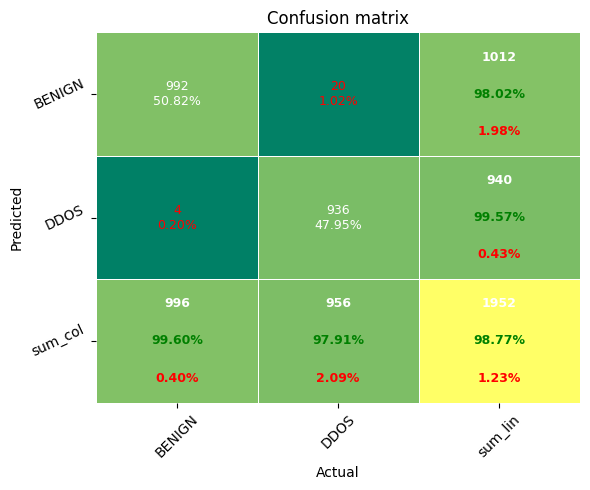

Acurácia: 	98.77
Precisão: 	99.57
Recall: 	97.91
F1-Score: 	98.73
ROC-AUC: 	98.75
Relatório de Classificação: 
              precision    recall  f1-score   support

      BENIGN       0.98      1.00      0.99       996
        DDoS       1.00      0.98      0.99       956

    accuracy                           0.99      1952
   macro avg       0.99      0.99      0.99      1952
weighted avg       0.99      0.99      0.99      1952



In [26]:
keras.utils.set_random_seed(1699153754)
#print(int(time.time()))

y_train = y_trainn
y_testt = y_test
# Aplica One Hot Encoding nos Alvos ( y )
y_testt = np_utils.to_categorical(y_testt)
y_train = np_utils.to_categorical(y_train)

print("Treinando Modelo...\n")
# -------------------- DEFINE MODELO E TREINA --------------------

# HIPERPARÂMETROS
txLearn = 0.01                      # Taxa de Aprendizagem
# CRITÉRIOS DE PARADA
maxValFail = 6                      # Quantidade máxima de falhas de validação
maxEpochs = 100                     # Quantidade máxima de Épocas
# TREINAMENTO E VALIDAÇÃO
qtdValid = 0.33                     # % do conjunto de treinamento direcionado para validação
shuffle = True                      # Embaralhar dados
# ----------------------------------------------------------------------------------------------------------------------------

model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(2, activation='softmax'))
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=maxValFail)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=maxEpochs, batch_size=100, validation_split=qtdValid, 
                    callbacks=[early_stopping], verbose=1)

print("\nFazendo teste...")
# -------------------- REALIZA A PREDIÇÃO --------------------
# Faz o teste
y_pred_mlp = model.predict(X_test)

# Desfaz operação de One-Hot-Encoding
y_pred_mlp = np.argmax (y_pred_mlp, axis = -1)
y_testt = np.argmax(y_testt, axis = -1)

# Discretiza o resultado do teste
y_pred_mlp = y_pred_mlp.round()

print("\nPlotando Matriz de Confusão...")
# -------------------- PLOTA MATRIZ DE CONFUSÃO --------------------

pp_matrix_from_data(y_testt, y_pred_mlp, cmap="summer", cbar=True, columns=classes, 
                    show_null_values=1, fz=9, figsize=[6,5])     # Plota

# Exibe todas as métricas
metrics_score(y_test, y_pred_mlp)

In [27]:
# ============= (MLP) ANÁLISE DE DESEMPENHO COM VALIDAÇÃO CRUZADA =============
mlp_manual_cross_validation(model, X_train, y_trainn, k=5)

MLP:

24/24 [==============================] - 0s 2ms/step
Resultados da Validação Cruzada (5-fold):
Exatidão em cada dobra: [0.9828496042216359, 0.9815303430079155, 0.9867899603698811, 0.9933949801849405, 0.9841479524438573]
Exatidão Média na Validação Cruzada: 0.985742568045646
Desvio Padrão na Validação Cruzada: 0.004202649654764752


### Decision Tree

/tmp/ipykernel_32/2958256902.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


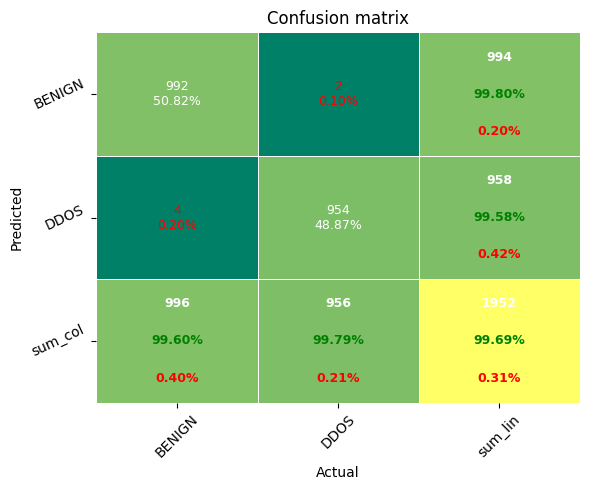

Acurácia: 	99.69
Precisão: 	99.58
Recall: 	99.79
F1-Score: 	99.69
ROC-AUC: 	99.69
Relatório de Classificação: 
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       996
        DDoS       1.00      1.00      1.00       956

    accuracy                           1.00      1952
   macro avg       1.00      1.00      1.00      1952
weighted avg       1.00      1.00      1.00      1952



In [28]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=seed)
clf = clf.fit(X_train, y_trainn)
y_pred_dt = clf.predict(X_test)

pp_matrix_from_data(y_test, y_pred_dt, cmap="summer", cbar=True, columns=classes, 
                    show_null_values=1, fz=9, figsize=[6,5])     # Plota

# Exibe todas as métricas
metrics_score(y_test, y_pred_dt)

### Random Forest


Treinando Modelo...

Fazendo teste...
Tempo de Teste: 	0.03


/tmp/ipykernel_32/2958256902.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


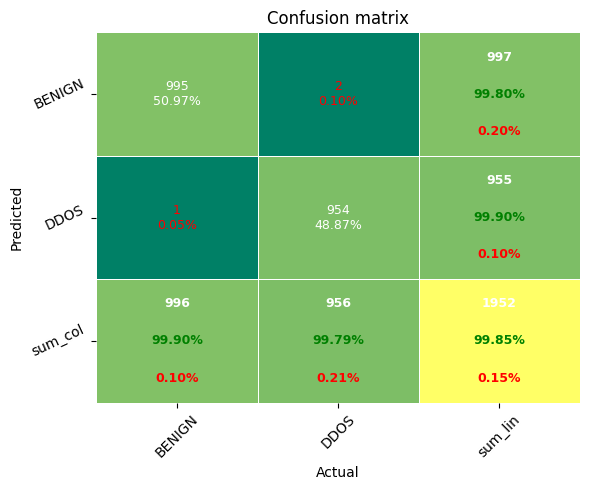

Acurácia: 	99.85
Precisão: 	99.90
Recall: 	99.79
F1-Score: 	99.84
ROC-AUC: 	99.85
Relatório de Classificação: 
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00       996
        DDoS       1.00      1.00      1.00       956

    accuracy                           1.00      1952
   macro avg       1.00      1.00      1.00      1952
weighted avg       1.00      1.00      1.00      1952



In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\nTreinando Modelo...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_model.fit(X_train, y_trainn)

print("\nFazendo teste...")
start = time.time()
y_pred_rf = rf_model.predict(X_test)
end = time.time()
print('Tempo de Teste: \t{:.2f}'.format(end - start))

pp_matrix_from_data(y_test, y_pred_rf, cmap="summer", cbar=True, columns=classes, 
                    show_null_values=1, fz=9, figsize=[6,5])     # Plota

class_report = classification_report(y_test, y_pred_rf)

# Exibe todas as métricas
metrics_score(y_test, y_pred_rf)

##### ANÁLISE DE DESEMPENHO COM VALIDAÇÃO CRUZADA

In [30]:
# ============= ANÁLISE DE DESEMPENHO COM VALIDAÇÃO CRUZADA =============
# ------------- para Random Forest (RF) e Árvore de Decisão -------------

from sklearn.model_selection import cross_val_score, KFold

models = {'Árvore de Decisão':clf, 'Random Forest':rf_model}

k = 5                   # Nº de folds (k) que os dados de entrada serão divididos
kf = KFold(n_splits=k, shuffle=True, random_state=42) # Objeto KFold que divide os dados em 'k' folds

for model in models.keys():
    print(f"{model}:\n")
    scores = cross_val_score(models[model], X_train, y_trainn, cv=kf, scoring='accuracy')   # Faz validação cruzada e pega score
    print('Pontuações de desempenho para cada fold:', scores)
    print('Acurácia média: {}'.format(scores.mean()))
    print(f"Desvio Padrão na Validação Cruzada: {scores.std()}\n")

Árvore de Decisão:

Pontuações de desempenho para cada fold: [0.99340369 0.99736148 0.99603699 0.998679   0.99471598]
Acurácia média: 0.9960394279599726
Desvio Padrão na Validação Cruzada: 0.0018662121078356264

Random Forest:

Pontuações de desempenho para cada fold: [0.99604222 0.99736148 0.99735799 1.         0.99735799]
Acurácia média: 0.9976239356158703
Desvio Padrão na Validação Cruzada: 0.0012928924104535597



##### EXTRAINDO ATRIBUTOS MAIS IMPORTANTES COM FEATURE DO RANDOM FOREST

In [31]:
# ============= EXTRAINDO ATRIBUTOS MAIS IMPORTANTES COM FEATURE DO RANDOM FOREST =============

feature_names = T.columns[:-1] # Lista com Nome de todas colunas, exceto 'Label'
print("Qtd Colunas: {}".format(len(feature_names)))

# Obtendo importância dos atributos a partir do modelo
feature_importance = rf_model.feature_importances_

# Criando DataFrame para associar as importâncias aos nomes dos recursos
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordena por importância em ordem decrescente (maior para menor)
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Seleciona 30% dos atributos mais importantes
qtd = round(len(importances_df)*0.3)
importances_df_30 = importances_df.iloc[:qtd,:]

# Exibe os recursos mais importantes
print(f"\nQntd 30% features: {len(importances_df_30)}")
print("\n30% Mais importantes:\n\n{}".format(list(importances_df_30['Feature'])))
print(f"\nSoma da Importância de  30% das features: {importances_df_30['Importance'].sum()}")
print(f"\nSoma da Importância de todas as features: {importances_df['Importance'].sum()}")
print(f'\nMédia Importance TODAS features: {feature_importance.mean()}')
print("\nLista de TODAS Colunas X Importância")
print("\n{}".format(importances_df.to_string(index=False)))

Qtd Colunas: 8

Qntd 30% features: 2

30% Mais importantes:

['Avg Fwd Segment Size', 'Subflow Bwd Packets']

Soma da Importância de  30% das features: 0.5413077489544929

Soma da Importância de todas as features: 1.0

Média Importance TODAS features: 0.125

Lista de TODAS Colunas X Importância

               Feature  Importance
  Avg Fwd Segment Size    0.381075
   Subflow Bwd Packets    0.160232
           Bwd IAT Min    0.130692
Init_Win_bytes_forward    0.105467
         Down/Up Ratio    0.068690
              Protocol    0.052031
      act_data_pkt_fwd    0.051779
Bwd Packet Length Mean    0.050034


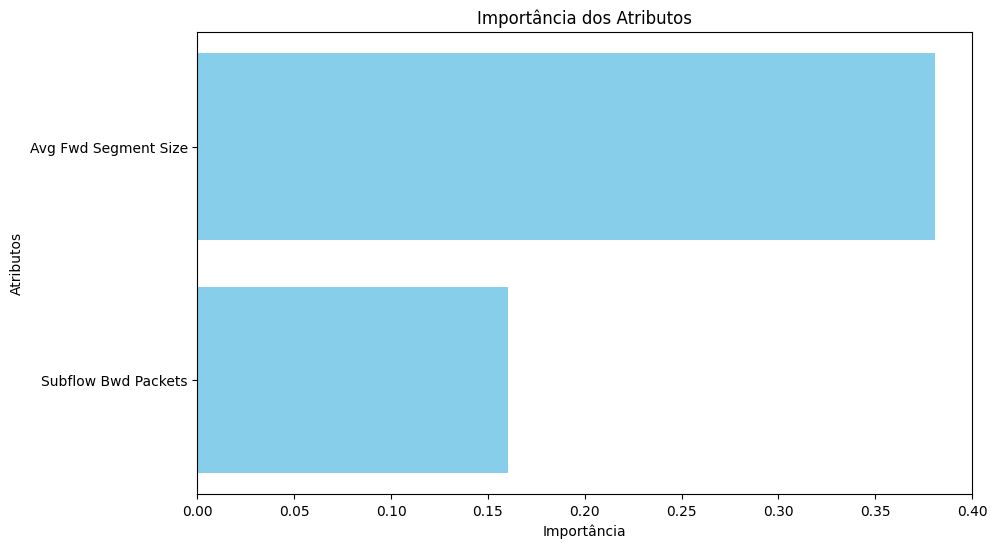

In [32]:
df = importances_df_30        # 30% dos atributos mais importantes
plt.figure(figsize=(10, 6))
plt.barh(df['Feature'], df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Atributos')
plt.title('Importância dos Atributos')
plt.gca().invert_yaxis()  # Inverte o eixo y para a feature mais importante ficar no topo
plt.show()

### Support Vector Machine


Treinando modelo...
Tempo de Treino: 	8.16

Fazendo teste...
Tempo de Teste: 	0.01


/tmp/ipykernel_32/2958256902.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]


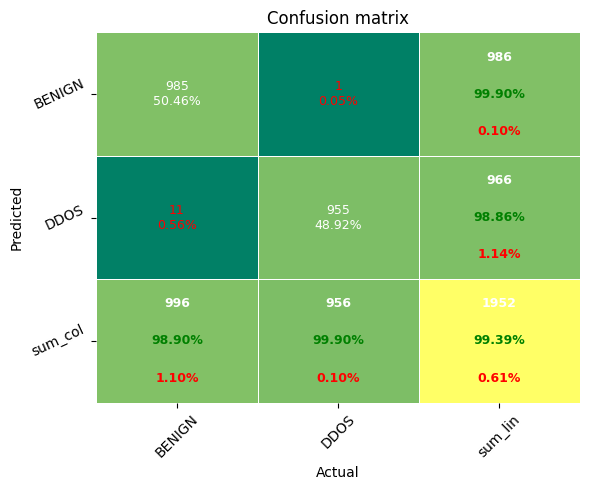

Acurácia: 	99.39
Precisão: 	98.86
Recall: 	99.90
F1-Score: 	99.38
ROC-AUC: 	99.40
Relatório de Classificação: 
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      0.99       996
        DDoS       0.99      1.00      0.99       956

    accuracy                           0.99      1952
   macro avg       0.99      0.99      0.99      1952
weighted avg       0.99      0.99      0.99      1952



In [33]:
from sklearn.svm import SVC

print("\nTreinando modelo...")

svm_model = SVC(kernel="poly", gamma="auto", C=1e7, random_state=seed)

start = time.time() # tempo inicial antes de treinar 
svm_model.fit(X_train, y_trainn)
end = time.time()   # tempo final depois de treinar

print('Tempo de Treino: \t{:.2f}'.format(end - start))

print("\nFazendo teste...")

start = time.time()
y_pred_svm = svm_model.predict(X_test)
end = time.time()
print('Tempo de Teste: \t{:.2f}'.format(end - start))

pp_matrix_from_data(y_test, y_pred_svm, cmap="summer", cbar=True, columns=classes, 
                    show_null_values=1, fz=9, figsize=[6,5])     # Plota

class_report = classification_report(y_test, y_pred_svm)

# Exibe todas as métricas
metrics_score(y_test, y_pred_svm)

### PLOTAR GRÁFICOS EM BARRAS

/tmp/ipykernel_32/1854733018.py:30: UserWarning: The label '_container5' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
/tmp/ipykernel_32/1854733018.py:30: UserWarning: The label '_container6' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda


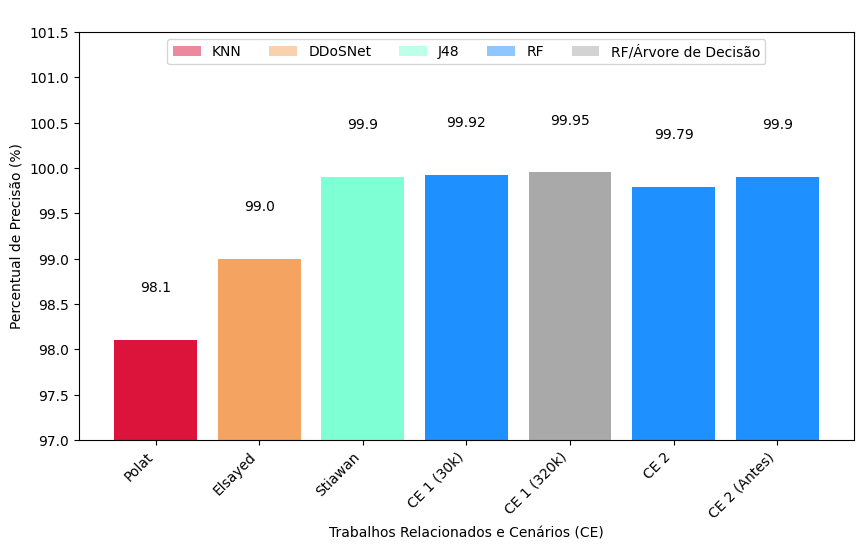

/tmp/ipykernel_32/1854733018.py:61: UserWarning: The label '_container6' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
/tmp/ipykernel_32/1854733018.py:61: UserWarning: The label '_container7' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda


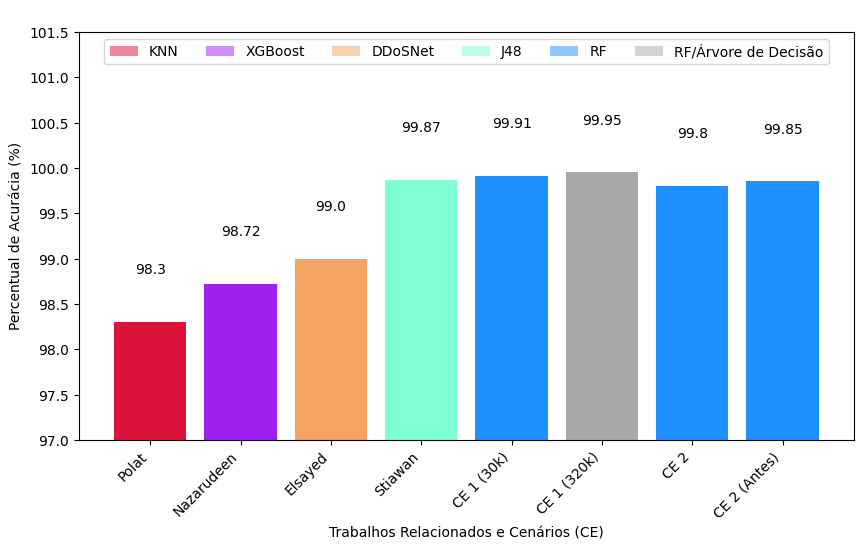

In [2]:
import matplotlib.pyplot as plt

#Trab (51) - Polat 
#Trab (52) - Nazarudeen
#Trab (53) - Elsayed
#Trab (55) - Stiawan

# Dados para o gráfico de exemplo
valores = [98.10, 99.00, 99.90, 99.92, 99.95, 99.79, 99.90]
#nomes = ['Trab (51)', 'Trab (53)', 'Trab (55)','CE 1 (30k)','CE 1 (320k)','CE 2','CE 2 (Antes)']
nomes = ['Polat', 'Elsayed', 'Stiawan','CE 1 (30k)','CE 1 (320k)','CE 2','CE 2 (Antes)']
modelos = ['KNN','DDoSNet','J48','RF','RF/Árvore de Decisão','','']
cores = ['#DC143C','#F4A460','#7FFFD4','#1E90FF','#A9A9A9','#1E90FF','#1E90FF']
plt.figure(figsize=(10, 6))
# Criando barras invisíveis para a legenda das cores
legend_bars = [plt.bar(0, 0, alpha=0.5, color=c, label=f'{m}') for c, m in zip(cores, modelos)]

# Criando o gráfico de barras
plt.bar(nomes, valores, color=cores)

# Adicionando os valores sobre cada barra
for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, f'{valores[i]}', ha='center', va='bottom')

# Configurações do gráfico
plt.xlabel('Trabalhos Relacionados e Cenários (CE)')
plt.ylabel('Percentual de Precisão (%)')
plt.title(' ')
plt.ylim(97, 101.5)  # Ajustando o limite do eixo y para melhor visualização
plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos e alinhando à direita
plt.subplots_adjust(bottom=0.2) # Ajustando o espaço na parte inferior para acomodar os rótulos

# Exibindo o gráfico
plt.show()

#============================

# Dados para o gráfico de exemplo
valores = [98.30, 98.72, 99.00, 99.87, 99.91, 99.95, 99.80, 99.85]
#nomes = ['Trab (51)', 'Trab (52)', 'Trab (53)', 'Trab (55)','CE 1 (30k)','CE 1 (320k)','CE 2','CE 2 (Antes)']
nomes = ['Polat', 'Nazarudeen', 'Elsayed', 'Stiawan','CE 1 (30k)','CE 1 (320k)','CE 2','CE 2 (Antes)']
modelos = ['KNN','XGBoost','DDoSNet','J48','RF','RF/Árvore de Decisão','','']
cores = ['#DC143C','#A020F0','#F4A460','#7FFFD4','#1E90FF','#A9A9A9','#1E90FF','#1E90FF']
plt.figure(figsize=(10, 6))
# Criando barras invisíveis para a legenda das cores
legend_bars = [plt.bar(0, 0, alpha=0.5, color=c, label=f'{m}') for c, m in zip(cores, modelos)]

# Criando o gráfico de barras
plt.bar(nomes, valores, color=cores)

# Adicionando os valores sobre cada barra
for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, f'{valores[i]}', ha='center', va='bottom')

# Configurações do gráfico
plt.xlabel('Trabalhos Relacionados e Cenários (CE)')
plt.ylabel('Percentual de Acurácia (%)')
plt.title(' ')
plt.ylim(97, 101.5)  # Ajustando o limite do eixo y para melhor visualização
plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos e alinhando à direita
plt.subplots_adjust(bottom=0.2) # Ajustando o espaço na parte inferior para acomodar os rótulos

# Exibindo o gráfico
plt.show()


/tmp/ipykernel_32/2777504900.py:24: UserWarning: The label '_container2' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
/tmp/ipykernel_32/2777504900.py:24: UserWarning: The label '_container3' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda


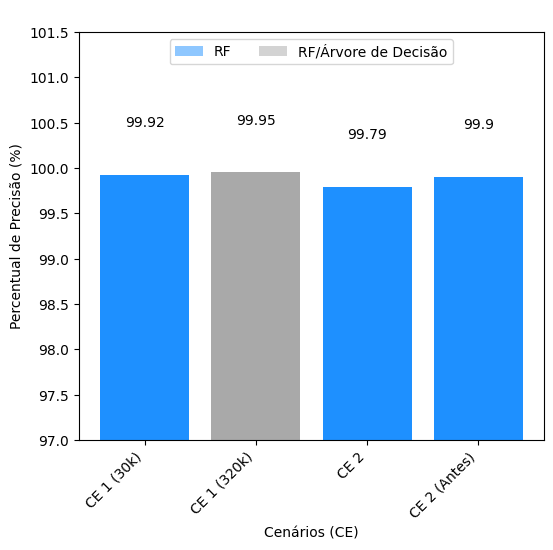

/tmp/ipykernel_32/2777504900.py:54: UserWarning: The label '_container2' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
/tmp/ipykernel_32/2777504900.py:54: UserWarning: The label '_container3' of <BarContainer object of 1 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda


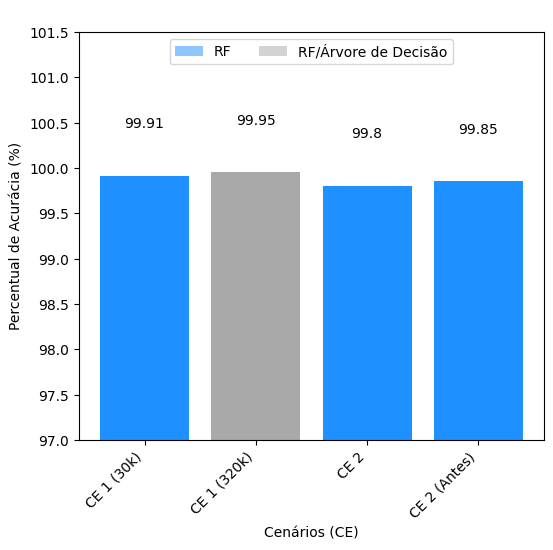

In [12]:
import matplotlib.pyplot as plt

# Dados para o gráfico de exemplo
valores = [99.92, 99.95, 99.79, 99.90]
nomes = ['CE 1 (30k)','CE 1 (320k)','CE 2','CE 2 (Antes)']
modelos = ['RF','RF/Árvore de Decisão','','']
cores = ['#1E90FF','#A9A9A9','#1E90FF','#1E90FF']
plt.figure(figsize=(6, 6))
# Criando barras invisíveis para a legenda das cores
legend_bars = [plt.bar(0, 0, alpha=0.5, color=c, label=f'{m}') for c, m in zip(cores, modelos)]

# Criando o gráfico de barras
plt.bar(nomes, valores, color=cores)

# Adicionando os valores sobre cada barra
for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, f'{valores[i]}', ha='center', va='bottom')

# Configurações do gráfico
plt.xlabel('Cenários (CE)')
plt.ylabel('Percentual de Precisão (%)')
plt.title(' ')
plt.ylim(97, 101.5)  # Ajustando o limite do eixo y para melhor visualização
plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos e alinhando à direita
plt.subplots_adjust(bottom=0.2) # Ajustando o espaço na parte inferior para acomodar os rótulos

# Exibindo o gráfico
plt.show()

#============================

# Dados para o gráfico de exemplo
valores = [99.91, 99.95, 99.80, 99.85]
nomes = ['CE 1 (30k)','CE 1 (320k)','CE 2','CE 2 (Antes)']
modelos = ['RF','RF/Árvore de Decisão','','']
cores = ['#1E90FF','#A9A9A9','#1E90FF','#1E90FF']
plt.figure(figsize=(6, 6))
# Criando barras invisíveis para a legenda das cores
legend_bars = [plt.bar(0, 0, alpha=0.5, color=c, label=f'{m}') for c, m in zip(cores, modelos)]

# Criando o gráfico de barras
plt.bar(nomes, valores, color=cores)

# Adicionando os valores sobre cada barra
for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, f'{valores[i]}', ha='center', va='bottom')

# Configurações do gráfico
plt.xlabel('Cenários (CE)')
plt.ylabel('Percentual de Acurácia (%)')
plt.title(' ')
plt.ylim(97, 101.5)  # Ajustando o limite do eixo y para melhor visualização
plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos e alinhando à direita
plt.subplots_adjust(bottom=0.2) # Ajustando o espaço na parte inferior para acomodar os rótulos

# Exibindo o gráfico
plt.show()


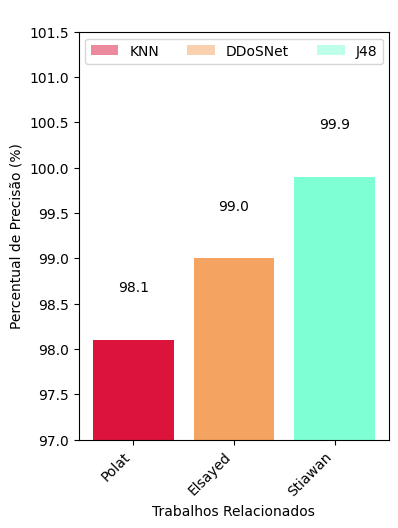

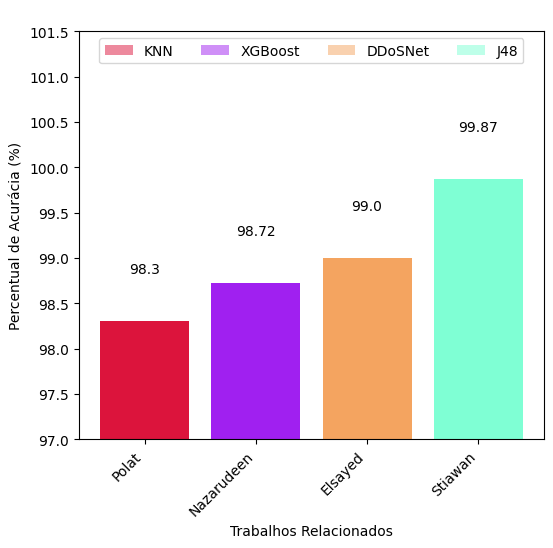

In [1]:
import matplotlib.pyplot as plt

# Dados para o gráfico de exemplo
valores = [98.10, 99.00, 99.90]
#nomes = ['Trab (51)', 'Trab (53)', 'Trab (55)']
nomes = ['Polat', 'Elsayed', 'Stiawan']
modelos = ['KNN','DDoSNet','J48']
cores = ['#DC143C','#F4A460','#7FFFD4']
plt.figure(figsize=(4, 6))
# Criando barras invisíveis para a legenda das cores
legend_bars = [plt.bar(0, 0, alpha=0.5, color=c, label=f'{m}') for c, m in zip(cores, modelos)]

# Criando o gráfico de barras
plt.bar(nomes, valores, color=cores)

# Adicionando os valores sobre cada barra
for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, f'{valores[i]}', ha='center', va='bottom')

# Configurações do gráfico
plt.xlabel('Trabalhos Relacionados')
plt.ylabel('Percentual de Precisão (%)')
plt.title(' ')
plt.ylim(97, 101.5)  # Ajustando o limite do eixo y para melhor visualização
plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos e alinhando à direita
plt.subplots_adjust(bottom=0.2) # Ajustando o espaço na parte inferior para acomodar os rótulos

# Exibindo o gráfico
plt.show()

#============================

# Dados para o gráfico de exemplo
valores = [98.30, 98.72, 99.00, 99.87]
#nomes = ['Trab (51)', 'Trab (52)', 'Trab (53)', 'Trab (55)']
nomes = ['Polat', 'Nazarudeen', 'Elsayed', 'Stiawan']
modelos = ['KNN','XGBoost','DDoSNet','J48']
cores = ['#DC143C','#A020F0','#F4A460','#7FFFD4']
plt.figure(figsize=(6, 6))
# Criando barras invisíveis para a legenda das cores
legend_bars = [plt.bar(0, 0, alpha=0.5, color=c, label=f'{m}') for c, m in zip(cores, modelos)]

# Criando o gráfico de barras
plt.bar(nomes, valores, color=cores)

# Adicionando os valores sobre cada barra
for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, f'{valores[i]}', ha='center', va='bottom')

# Configurações do gráfico
plt.xlabel('Trabalhos Relacionados')
plt.ylabel('Percentual de Acurácia (%)')
plt.title(' ')
plt.ylim(97, 101.5)  # Ajustando o limite do eixo y para melhor visualização
plt.legend(handles=legend_bars, loc='upper center', ncol=len(nomes))  # Adicionando a legenda
plt.xticks(rotation=45, ha='right')  # Rotacionando os rótulos e alinhando à direita
plt.subplots_adjust(bottom=0.2) # Ajustando o espaço na parte inferior para acomodar os rótulos

# Exibindo o gráfico
plt.show()
